#**Análisis de Drivers de Ventas en la Industria de Videojuegos**

## Índice

- [Introducción](#introduccion)
- [Carga y exploración de datos](#carga-exploracion)
- [Limpieza y preparación de datos](#limpieza-preparacion)
- [Análisis exploratorio de datos (EDA)](#eda)
  - [Análisis de lanzamientos por año](#lanzamientos-ano)
  - [Ventas anuales y globales por plataforma](#ventas-plataformas)
  - [Tendencias de ventas en plataformas líderes](#tendencias-plataformas)
- [Segmentación regional del mercado](#segmentacion-regional)
  - [Análisis de cuota de mercado](#cuota-mercado)
  - [Segmentación por género](#segmentacion-genero)
  - [Segmentación por clasificación ESRB](#segmentacion-esrb)
- [Análisis de correlación](#correlacion)
- [Análisis inferencial: pruebas de hipótesis](#inferencial)
- [Conclusiones y recomendaciones](#conclusiones)

<a id="introduccion"></a>
## Introducción


Este análisis plantea en un escenario hipotético en el que la tienda online Ice busca planificar campañas publicitarias futuras a partir de información disponible hasta 2016.

El análisis consiste en la limpieza y preparación de los datos, un análisis exploratorio (EDA) para identificar los géneros y las plataformas líderes en venta por región y evaluar la correlación entre las reseñas de usuarios y críticos en el total de ventas; así como, un análisis estadístico mediante pruebas de hipótesis para comparar si las calificaciones promedio de usuarios son iguales o diferentes para las plataformas Xbox One y PC y los géneros de Acción y Deportes

<a id="carga-exploracion"></a>
## Carga y exploración de datos


En esta sección se realiza la carga del conjunto de datos y una exploración inicial
para comprender su estructura, variables disponibles y detectar posibles problemas
como valores faltantes o inconsistencias.

In [79]:
#Importar librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from scipy.stats import levene
import math

In [80]:
# Cargar archivos para obtener información preliminar de los datos

games= pd.read_csv("games.csv")
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<a id="limpieza-preparacion"></a>
## Limpieza y preparación de datos


En esta sección se realiza la preparación del conjunto de datos para su análisis posterior.
Se analizan los valores ausentes, se eliminan duplicados, se homogeneizan los nombres de
las columnas y se verifica que los tipos de datos sean los adecuados para cada variable.

Las decisiones adoptadas fueron las siguientes:
- Los valores faltantes en variables categóricas (`name`, `genre`, `rating`)
  se reemplazaron por `"unknown"` para conservar los registros.
- Los registros sin información de `year_of_release` fueron eliminados,
  ya que el análisis depende del contexto temporal.
- Los valores faltantes en `critic_score` y `user_score` se mantuvieron como nulos
  inicialmente, debido a la falta de información suficiente para una imputación directa.

In [81]:

#Estandarizar nombres de columnas
games.columns=["name","platform","year_of_release","genre","na_sales",
               "eu_sales","jp_sales", "other_sales", "critic_score",
               "user_score","rating"]

#Verificar registros duplicados
print("\nRegistro de duplicados:\n",games.duplicated().sum())

#Identificar valores ausentes por columna
print("\nVerificación de valores ausentes:\n",games.isna().sum())

# Completar valores faltantes en variables categóricas
games["name"]=games["name"].fillna("unknown")
games["genre"]=games["genre"].fillna("unknown")
games["rating"]=games["rating"].fillna("unknown")

#Eliminar registros sin año de lanzamiento
games=games.dropna(subset=["year_of_release"])

# Revisar tipos de datos originales
print("\nTipo de dato original:\n",games.dtypes)

#Ajustar tipos de dato
games["rating"]= games["rating"].astype("category")
games["year_of_release"] = games["year_of_release"].astype("int64")

# Convertir puntaje de usuarios a numérico (valores no válidos se convierten en NaN)
games["user_score"] = pd.to_numeric(games["user_score"], errors="coerce")

# Confirmar cambios de tipo de dato
print("\nCambio del tipo de dato:\n",games.dtypes)

#Procesar los tbd de user_score
games["user_score"]=games["user_score"].replace("tbd",pd.NA)



Registro de duplicados:
 0

Verificación de valores ausentes:
 name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Tipo de dato original:
 name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Cambio del tipo de dato:
 name                 object
platform             object
year_of_release       int64
genre                object
na_sales            float64
eu_sales            float64
jp_sales            float64
other_sales         float64
critic_score        float64
user_score          float64
rating          

<a id="eda"></a>
## Análisis exploratorio de datos (EDA)


### Ventas y ciclo de vida de plataformas

En esta sección se analizan las plataformas con mayores ventas globales y su evolución temporal, con el objetivo de identificar patrones de ciclo de vida y periodos de mayor relevancia comercial.


<a id="lanzamientos-ano"></a>
### Análisis de lanzamientos por año


In [82]:
# Calcular las ventas globales como la suma de las ventas por región
games["global_sales"] = (
    games["na_sales"] +
    games["eu_sales"] +
    games["jp_sales"] +
    games["other_sales"]
)

# Verificar las primeras filas del dataset
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [83]:
# Calcular el número de videojuegos lanzados por año
games_per_year = (
    games.groupby("year_of_release")["name"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

games_per_year.columns = ["year", "num_games"]

# Definir años significativos usando la mediana como umbral
median_games = games_per_year["num_games"].median()

significant_years = games_per_year[
    games_per_year["num_games"] >= median_games
]




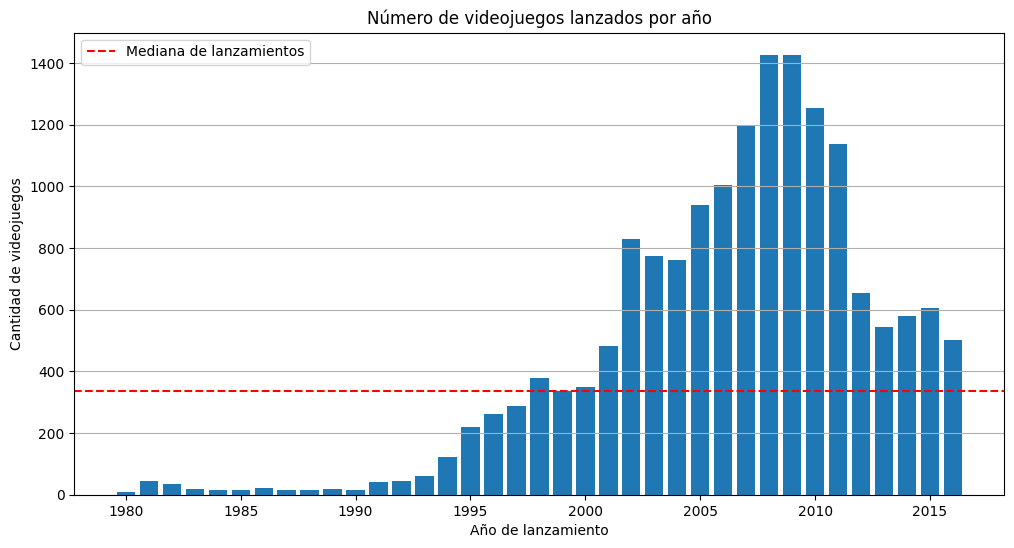

In [84]:
plt.figure(figsize=(12, 6))

plt.bar(
    games_per_year["year"],
    games_per_year["num_games"]
)

plt.axhline(
    y=median_games,
    color="red",
    linestyle="--",
    label="Mediana de lanzamientos"
)

plt.title("Número de videojuegos lanzados por año")
plt.xlabel("Año de lanzamiento")
plt.ylabel("Cantidad de videojuegos")
plt.legend()
plt.grid(axis="y")
plt.show()

El número de lanzamientos anuales es considerablemente bajo en los años previos al 2000 en comparación con el periodo posterior. Con base en la mediana del número de lanzamientos por año, se identificó un cambio claro en la dinámica del mercado a partir del año 2000.
Por esta razón, los registros posteriores al 2000 se consideran más representativos y estadísticamente relevantes para el análisis, ya que reflejan un mercado más activo, diversificado y comparable con la industria actual de los videojuegos.


<a id="ventas-plataformas"></a>
### Ventas anuales y globales por plataforma


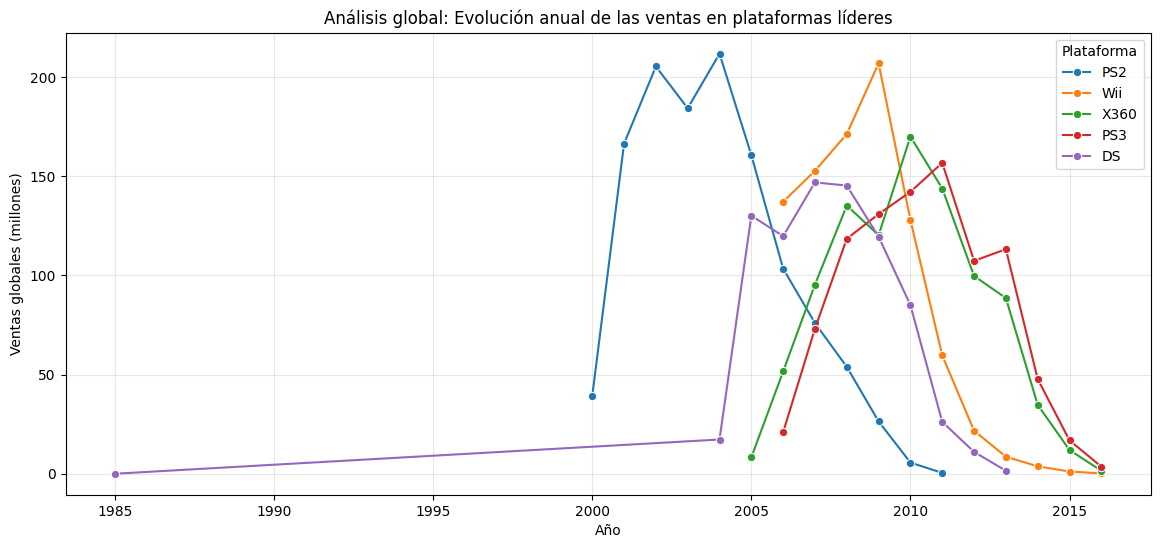

In [85]:
# Calcular las ventas anuales totales por plataforma
sales_platform_year = (
    games.groupby(["platform", "year_of_release"])["global_sales"]
    .sum()
    .reset_index()
)

sales_platform_year.columns = ["platform", "year", "total_sales"]

# Calcular las ventas globales acumuladas por plataforma
sales_platforms = (
    games.groupby("platform")["global_sales"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

sales_platforms.columns = ["platform", "total_sales"]

# Seleccionar las 5 plataformas con mayores ventas globales
top_platforms = sales_platforms.head(5)["platform"]

# Filtrar las ventas anuales de las plataformas líderes
top_sales = (
    sales_platform_year[sales_platform_year["platform"].isin(top_platforms)]
    .sort_values(by="total_sales", ascending=False)
    .reset_index(drop=True)
)



# Visualizar la evolución anual de las ventas para las plataformas líderes
# con el fin de identificar periodos de crecimiento y declive

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=top_sales,
    x="year",
    y="total_sales",
    hue="platform",
    marker="o"
)

plt.title("Análisis global: Evolución anual de las ventas en plataformas líderes")
plt.xlabel("Año")
plt.ylabel("Ventas globales (millones)")
plt.legend(title="Plataforma")
plt.grid(True, alpha=0.3)

plt.show()


La PlayStation 2 se posicionó como la plataforma con mayores ventas globales, superando los 200 millones de unidades acumuladas; no obstante, a partir de 2005 se observa un declive progresivo en su desempeño comercial.

La Wii logró una rápida adopción y consolidación en el mercado, alcanzando volúmenes de ventas comparables a los de la PS2, aunque su periodo de auge fue considerablemente más corto.

Por su parte, la Nintendo DS mostró un comportamiento más estable entre 2005 y 2010, con ventas sostenidas pero sin alcanzar los picos máximos observados en PS2 o Wii.

Finalmente, entre 2010 y 2015, Xbox 360 y PlayStation 3 emergieron como las plataformas dominantes, marcando la transición hacia una nueva generación de consolas y un cambio en la dinámica del mercado.


In [86]:
#Para analizar el ciclo de vida comercial de las plataformas, se define un periodo relevante considerando únicamente aquellos años en los que las ventas globales superan los 10 millones de USD
#Este enfoque permite identificar con mayor precisión las fases de mayor impacto económico de cada plataforma.

# Calcular el periodo total de actividad de cada plataforma
platform_active = (
    sales_platform_year
    .groupby("platform")["year"]
    .agg(["min", "max"])
    .reset_index()
)

platform_active.columns = ["platform", "start_year", "end_year"]

# Definir un umbral de relevancia comercial:
# Se considera relevante un año con al menos 10 millones en ventas globales
relevant_sales = sales_platform_year[
    sales_platform_year["total_sales"] >= 10
].dropna(subset=["platform", "year"])

# Calcular el periodo relevante de actividad por plataforma
active_period = (
    relevant_sales
    .groupby("platform")
    .agg(
        relevant_start=("year", "min"),
        relevant_end=("year", "max"),
        max_sale=("total_sales", "max")
    )
    .reset_index()
)

# Identificar el año de mayor venta para cada plataforma
max_year_idx = relevant_sales.groupby("platform")["total_sales"].idxmax()

max_sale_year = (
    relevant_sales
    .loc[max_year_idx, ["platform", "year"]]
    .rename(columns={"year": "max_income_year"})
)

# Unir la información en un solo DataFrame
active_period = (
    active_period
    .merge(max_sale_year, on="platform")
    .sort_values(by="max_sale", ascending=False)
    .reset_index(drop=True)
)

active_period


,platform,relevant_start,relevant_end,max_sale,max_income_year
0,PS2,2000,2009,211.81,2004
1,Wii,2006,2012,206.97,2009
2,X360,2006,2015,170.03,2010
3,PS,1995,2001,169.49,1998
4,PS3,2006,2015,156.78,2011
5,DS,2004,2012,146.94,2007
6,PS4,2013,2016,118.90,2015
7,GBA,2001,2005,77.91,2004
8,XB,2001,2006,65.42,2004
9,GB,1989,2000,64.97,1989


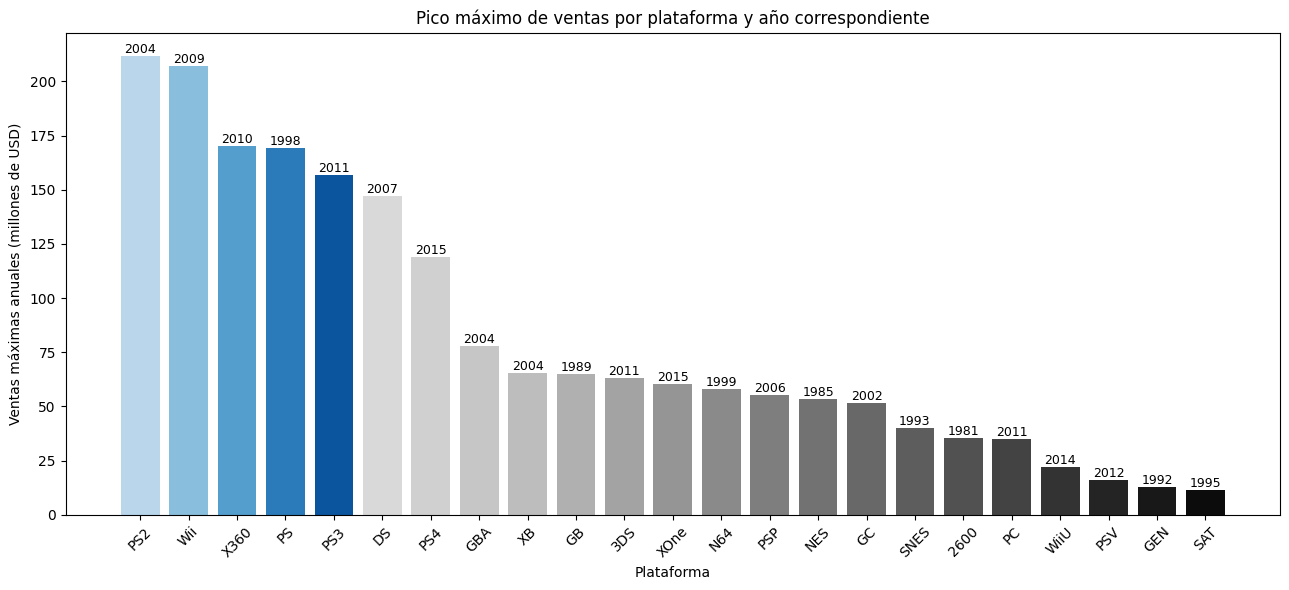

In [87]:

# Ordenar plataformas por ventas máximas
active_period_sorted = active_period.sort_values(
    by="max_sale", ascending=False
).reset_index(drop=True)


blue_palette = sns.color_palette("Blues", 6)[1:]
gray_palette = sns.color_palette("Greys", len(active_period_sorted))

colors = [
    blue_palette[i] if i < 5 else gray_palette[i]
    for i in range(len(active_period_sorted))
]

plt.figure(figsize=(13, 6))

bars = plt.bar(
    active_period_sorted["platform"],
    active_period_sorted["max_sale"],
    color=colors
)

# Agregar el año del pico de ventas sobre cada barra
for bar, year in zip(bars, active_period_sorted["max_income_year"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(year)}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.title("Pico máximo de ventas por plataforma y año correspondiente")
plt.xlabel("Plataforma")
plt.ylabel("Ventas máximas anuales (millones de USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A nivel global, las plataformas que lideraron el mercado en términos de ventas anuales fueron PlayStation 2 y Wii, ambas superando los 200 millones de USD en los años 2004 y 2009, respectivamente. En un segundo nivel se encuentran Xbox 360, PlayStation y PlayStation 3, las cuales alcanzaron ventas superiores a los 150 millones de USD en 2010, 1998 y 2011.

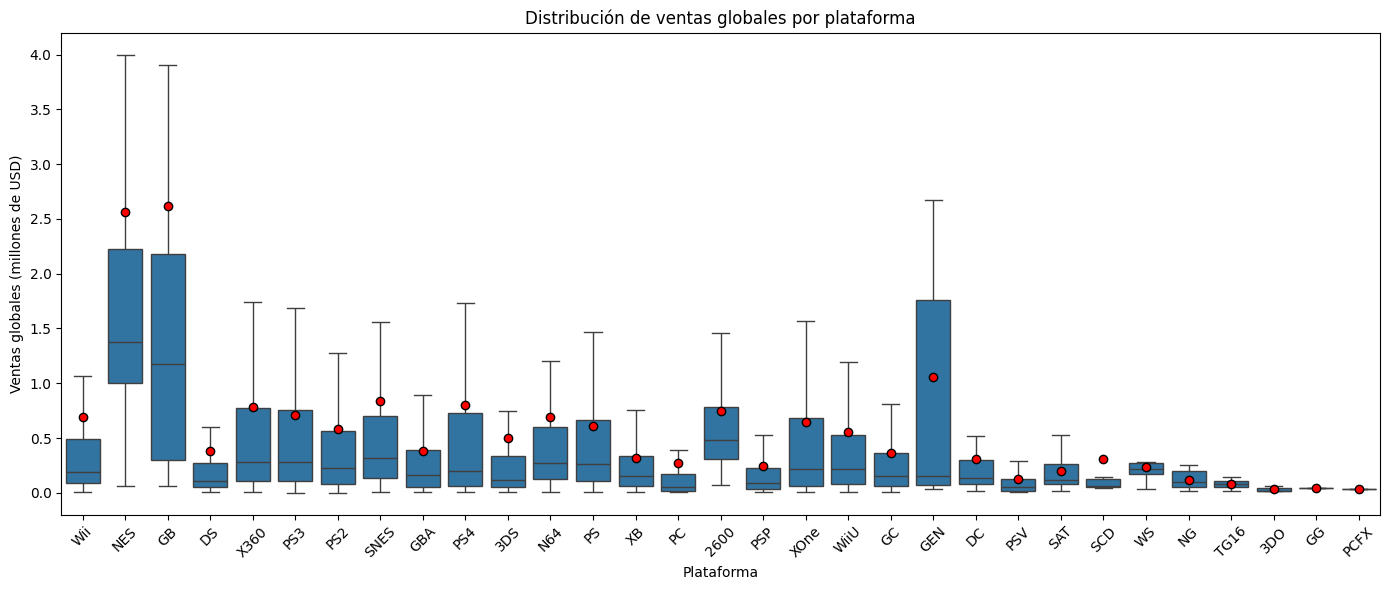

In [88]:
# Boxplot de ventas globales por plataforma
# Se ocultan outliers para facilitar la comparación entre distribuciones

plt.figure(figsize=(14, 6))

sns.boxplot(
    x="platform",
    y="global_sales",
    data=games,
    showfliers=False,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "red",
        "markeredgecolor": "black"
    }
)

plt.xticks(rotation=45)
plt.title("Distribución de ventas globales por plataforma")
plt.xlabel("Plataforma")
plt.ylabel("Ventas globales (millones de USD)")

plt.tight_layout()
plt.show()


Mientras que la gráfica anterior evidenció picos máximos de ventas anuales concentrados en ciertos años y plataformas, este análisis revela que dichos picos no siempre reflejan un desempeño consistente del catálogo completo. Plataformas como PS2 y Wii dominaron el mercado en términos de volumen total y años pico; sin embargo, consolas como NES y GB muestran una mayor consistencia en ventas por título, lo que sugiere un modelo de éxito más distribuido. Este modelo es consistente con  las plataformas PS4, Xbox One y 3DS donde a pesar de que menos títulos alcanzan picos de venta históricos, el desempeño es más uniforme entre juegos que las convierte en plataformas rentables.

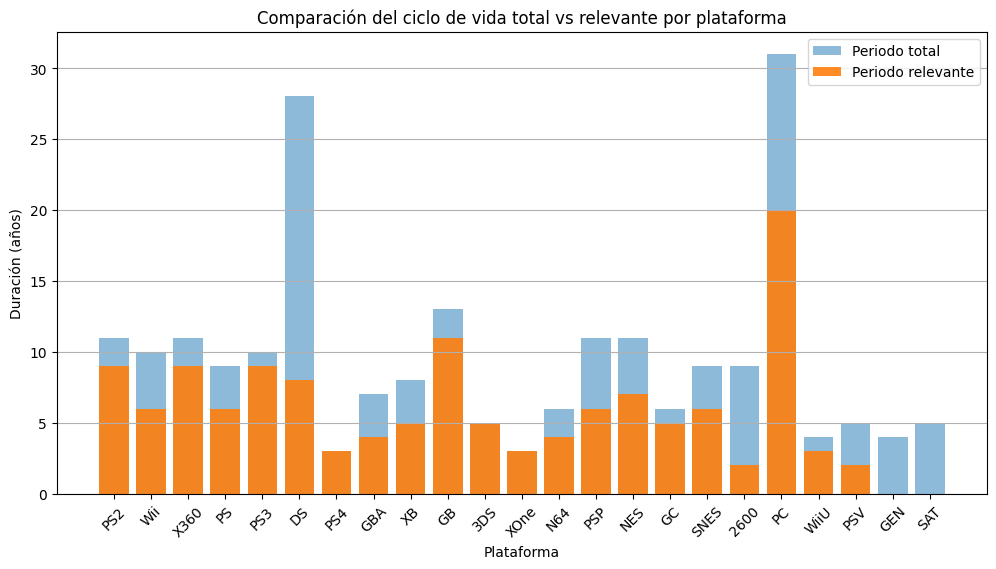

In [89]:
plt.figure(figsize=(12, 6))

plt.bar(
    relevant_total_period["platform"],
    relevant_total_period["end_year"] - relevant_total_period["start_year"],
    alpha=0.5,
    label="Periodo total"
)

plt.bar(
    relevant_total_period["platform"],
    relevant_total_period["relevant_end"] - relevant_total_period["relevant_start"],
    alpha=0.9,
    label="Periodo relevante"
)

plt.title("Comparación del ciclo de vida total vs relevante por plataforma")
plt.xlabel("Plataforma")
plt.ylabel("Duración (años)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

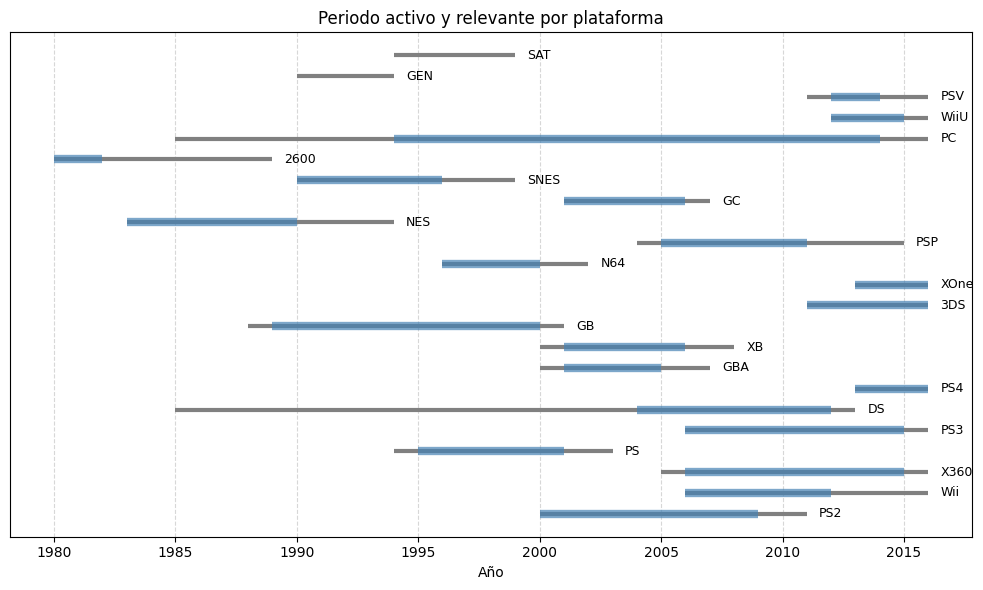

In [90]:
#Periodo activo total de cada plataforma, sin importar el número de ventas
platform_active=sales_platform_year.groupby("platform")["year"].agg(["min","max"])
platform_active.columns=["total_start","total_end"]

#Graficar periodo activo Vs periodo relevante por plataforma
platform_periods = relevant_total_period.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

for i, row in platform_periods.iterrows():
    # periodo activo
    ax.hlines(y=i, xmin=row["start_year"], xmax=row["end_year"], color='gray', linewidth=3, label='Periodo activo' if i == 0 else "")

    # periodo relevante
    ax.hlines(y=i, xmin=row['relevant_start'], xmax=row['relevant_end'], color='steelblue', linewidth=6, alpha=0.7, label='Periodo relevante' if i == 0 else "")

    ax.text(x=row["end_year"] + 0.5, y=i, s=row['platform'],
        va='center', ha='left', fontsize=9)



ax.set_yticks([])
ax.set_xlabel('Año')
ax.set_title('Periodo activo y relevante por plataforma')
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Las gráficas de ciclo de vida muestran que un periodo activo extenso no siempre se traduce en un periodo comercialmente relevante igual de largo. En varias plataformas, el grueso de las ventas se concentra en una fracción relativamente corta de su existencia, reforzando lo observado en los boxplots: el liderazgo histórico estuvo impulsado por ventanas temporales bien definidas y, en muchos casos, por un número limitado de títulos de alto impacto.

En contraste, las generaciones más recientes operan bajo una lógica distinta. El mercado posterior a 2010 se caracteriza por ciclos de vida más compactos, mayor solapamiento entre plataformas y una competencia más intensa, lo que reduce la duración del periodo de máxima relevancia comercial. Este cambio estructural explica por qué, aunque plataformas como PS4, Xbox One y Nintendo 3DS no alcanzan aún los picos históricos de generaciones previas, sí se posicionan como líderes dentro de su contexto temporal, con ventas sostenidas desde su lanzamiento.

En este contexto, el análisis se enfoca a partir de ahora en Xbox One, PlayStation 4 y Nintendo 3DS, al representar la fase más reciente del mercado con datos suficientemente maduros. Estas plataformas permiten evaluar cómo ha cambiado el comportamiento del consumo, la distribución de ventas y la duración del periodo relevante en un entorno moderno, marcado por mayor fragmentación del mercado y estrategias de lanzamiento más concentradas.

<a id="tendencias-plataformas"></a>
### Tendencias de ventas en plataformas líderes

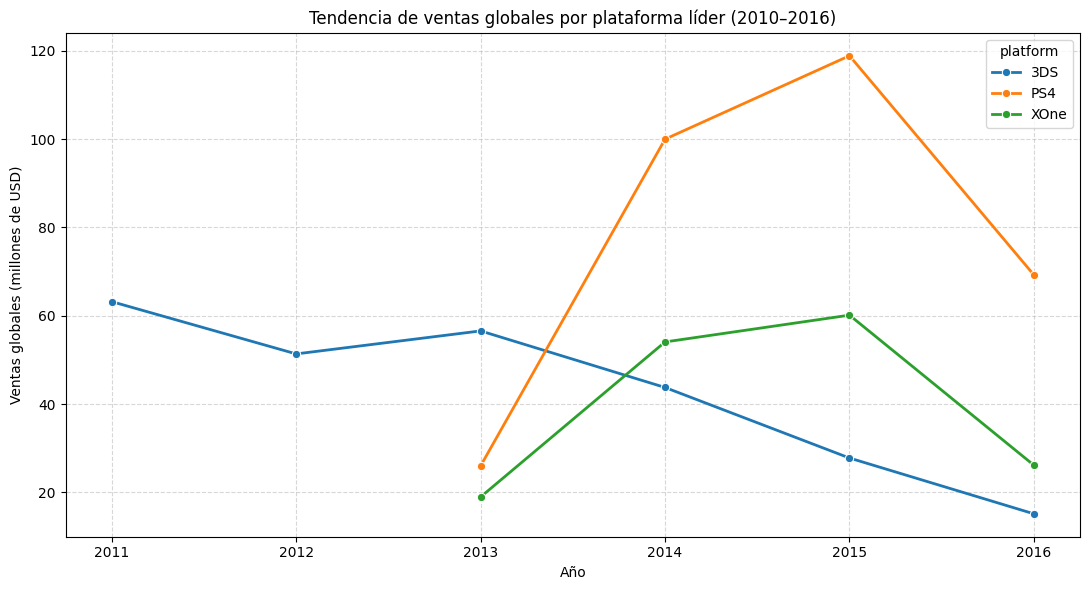

In [92]:
# Filtrar datos para el periodo relevante de proyección (2010–2016)
games_recent = games[
    (games["year_of_release"] >= 2010) &
    (games["year_of_release"] <= 2016)
].copy()

# Definir plataformas líderes (puedes ajustar si lo deseas)
top_platforms = ["PS4", "XOne", "3DS"]

# Filtrar solo plataformas líderes
games_leaders = games_recent[
    games_recent["platform"].isin(top_platforms)
]

# Calcular ventas globales por año y plataforma
sales_trend_leaders = (
    games_leaders
    .groupby(["year_of_release", "platform"])["global_sales"]
    .sum()
    .reset_index()
)

# Visualizar la tendencia de ventas
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=sales_trend_leaders,
    x="year_of_release",
    y="global_sales",
    hue="platform",
    marker="o",
    linewidth=2
)

plt.title("Tendencia de ventas globales por plataforma líder (2010–2016)")
plt.xlabel("Año")
plt.ylabel("Ventas globales (millones de USD)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Entre 2010 y 2016 se observa una transición clara del liderazgo del mercado hacia consolas de nueva generación. PlayStation 4 muestra el crecimiento más acelerado, alcanzando su pico de ventas en 2015, lo que refleja una adopción rápida y una estrategia de lanzamiento altamente efectiva. Aunque en 2016 se aprecia una desaceleración, la PS4 se consolida como la plataforma dominante del periodo.

Xbox One presenta un patrón similar, aunque con un volumen de ventas menor. Su crecimiento sostenido entre 2013 y 2015 indica una entrada competitiva al mercado; sin embargo, la caída posterior sugiere una menor retención del impulso comercial frente a su principal competidor.

Por otro lado, Nintendo 3DS exhibe una tendencia descendente a lo largo del periodo analizado. A pesar de un inicio sólido, sus ventas disminuyen progresivamente, lo que es consistente con una plataforma que entra en una fase madura de su ciclo de vida y comienza a ceder protagonismo frente a consolas más recientes.

En conjunto, estos resultados confirman que, en el periodo posterior a 2010, el mercado se caracteriza por ciclos de crecimiento más cortos y picos de ventas más concentrados, reforzando el cambio estructural observado en generaciones previas. Este comportamiento evidencia un entorno más competitivo, donde el liderazgo depende de una rápida adopción inicial más que de una estabilidad prolongada en el tiempo.

<a id="correlacion"></a>
## Análisis de correlación

Análisis de correlación entre calificaciones y ventas en una plataforma líder (PlayStation 4)

Promedio de ventas globales (PS4): 0.8013775510204081
Correlación critic_score vs ventas: 0.40656790206178095
Correlación user_score vs ventas: -0.031957110204556424


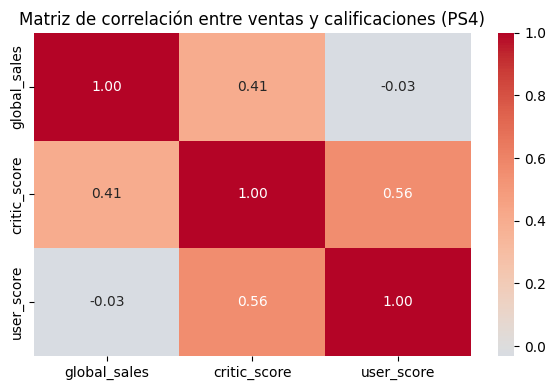

In [93]:
# Análisis del efecto de las reseñas en las ventas de una plataforma líder (PS4)

# Filtrar juegos de PS4
ps4_games = games[games['platform'] == 'PS4'].copy()

# Promedio de ventas globales
print("Promedio de ventas globales (PS4):", ps4_games['global_sales'].mean())

# Correlación entre ventas y calificaciones
print("Correlación critic_score vs ventas:",
      ps4_games['critic_score'].corr(ps4_games['global_sales']))

print("Correlación user_score vs ventas:",
      ps4_games['user_score'].corr(ps4_games['global_sales']))

# Homogeneizar escala de critic_score (0–100 → 0–10)
ps4_games['critic_score'] = (ps4_games['critic_score'] / 10).round(1)

# Matriz de correlación
corr = ps4_games[['global_sales', 'critic_score', 'user_score']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f"
)

plt.title('Matriz de correlación entre ventas y calificaciones (PS4)')
plt.tight_layout()
plt.show()


La matriz de correlación muestra que la relación entre el desempeño comercial y la recepción crítica es moderada, pero no determinante. Existe una correlación positiva entre las ventas globales y las calificaciones de la crítica (r = 0.41), lo que sugiere que los títulos mejor evaluados por especialistas tienden a vender más. En contraste la correlación entre ventas globales y calificaciones de usuarios es prácticamente nula (r = −0.03), indicando que la percepción del público no está directamente asociada al volumen de ventas.

En PS4, la calidad percibida contribuye al éxito comercial, pero no lo determina. Por lo tanto, el rendimiento en ventas responde a una combinación de factores estratégicos más allá de las calificaciones.

<a id="segmentacion-regional"></a>
## Segmentación regional del mercado

Análisis de géneros y plataformas líderes en Norteamérica, Europa y Japón

Con el fin de identificar diferencias regionales en las preferencias del mercado de videojuegos, se analizan las ventas por región para Norteamérica, Europa y Japón. Este análisis permite reconocer los géneros y plataformas que dominan cada mercado. La comparación regional proporciona un contexto clave para interpretar patrones globales y comprender la heterogeneidad del mercado a escala geográfica.

<a id="cuota-mercado"></a>
### Análisis de cuota de mercado


In [94]:
#Principales plataformas por región

games_recent = games[
    (games["year_of_release"] >= 2010) &
    (games["year_of_release"] <= 2016)
]

na_plataformas= games_recent.groupby("platform")["na_sales"].sum().sort_values(ascending=False).reset_index()
eu_plataformas= games_recent.groupby("platform")["eu_sales"].sum().sort_values(ascending=False).reset_index()
jp_plataformas= games_recent.groupby("platform")["jp_sales"].sum().sort_values(ascending=False).reset_index()

total_na=na_plataformas["na_sales"].sum()
total_eu=eu_plataformas["eu_sales"].sum()
total_jp=jp_plataformas["jp_sales"].sum()

na_plataformas["market_share"]=na_plataformas["na_sales"]/total_na*100
eu_plataformas["market_share"]=eu_plataformas["eu_sales"]/total_eu*100
jp_plataformas["market_share"]=jp_plataformas["jp_sales"]/total_jp*100





In [95]:
# Sacar las plataformas top 5 de cada región
na_top5_names = na_plataformas.nlargest(5, "market_share")["platform"]
eu_top5_names = eu_plataformas.nlargest(5, "market_share")["platform"]
jp_top5_names = jp_plataformas.nlargest(5, "market_share")["platform"]

# Lista de plataformas que son top 5 en al menos una región
top_platforms = pd.unique(pd.concat([na_top5_names, eu_top5_names, jp_top5_names]))

# Ahora filtramos los dataframes completos, no solo top5
na_top = na_plataformas[na_plataformas["platform"].isin(top_platforms)][["platform", "market_share"]]
eu_top = eu_plataformas[eu_plataformas["platform"].isin(top_platforms)][["platform", "market_share"]]
jp_top = jp_plataformas[jp_plataformas["platform"].isin(top_platforms)][["platform", "market_share"]]

# Unimos (outer join para no perder nada)
top_union = (na_top.merge(eu_top, on="platform", how="outer", suffixes=("_NA", "_EU"))
                  .merge(jp_top, on="platform", how="outer"))
top_union.rename(columns={"market_share": "market_share_JP"}, inplace=True)



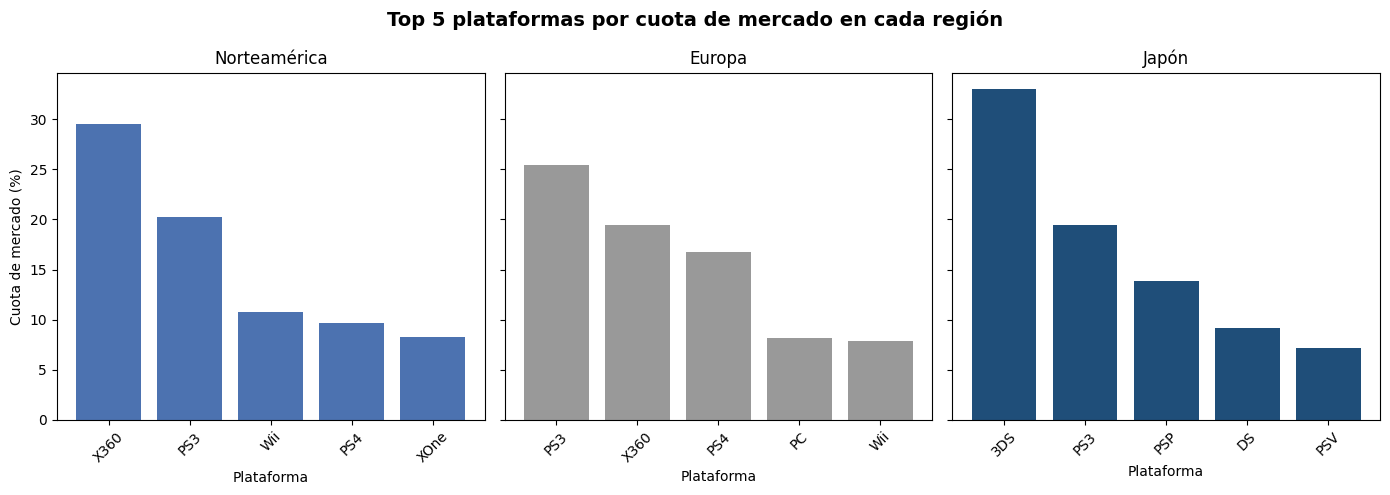

In [96]:
import matplotlib.pyplot as plt

# ---- TOP 3 por región a partir de top_union ----
top3_na = top_union.nlargest(5, "market_share_NA")
top3_eu = top_union.nlargest(5, "market_share_EU")
top3_jp = top_union.nlargest(5, "market_share_JP")

# ---- Crear subgráficas ----
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# Colores sobrios por región
color_na = "#4C72B0"   # azul
color_eu = "#999999"   # gris
color_jp = "#1F4E79"   # azul oscuro

# ---- Norteamérica ----
axes[0].bar(
    top3_na["platform"],
    top3_na["market_share_NA"],
    color=color_na
)
axes[0].set_title("Norteamérica")
axes[0].set_ylabel("Cuota de mercado (%)")
axes[0].set_xlabel("Plataforma")

# ---- Europa ----
axes[1].bar(
    top3_eu["platform"],
    top3_eu["market_share_EU"],
    color=color_eu
)
axes[1].set_title("Europa")
axes[1].set_xlabel("Plataforma")

# ---- Japón ----
axes[2].bar(
    top3_jp["platform"],
    top3_jp["market_share_JP"],
    color=color_jp
)
axes[2].set_title("Japón")
axes[2].set_xlabel("Plataforma")

# ---- Ajustes finales ----
for ax in axes:
    ax.tick_params(axis="x", rotation=45)

fig.suptitle(
    "Top 5 plataformas por cuota de mercado en cada región",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


El análisis de cuota de mercado revela diferencias regionales marcadas en el liderazgo de plataformas, que plataformas concentran mayor peso económico dentro de una región. Mientras que Norteamérica y Europa están dominadas por las plataformas de sobremesa Xbox 360 y PS3, Japón muestra una clara preferencia por plataformas portátiles, con Nintendo 3DS concentrando la mayor parte del mercado. Estos contrastes evidencian que el éxito comercial de una plataforma depende fuertemente del contexto regional, y refuerzan la importancia de analizar el mercado de forma segmentada para comprender patrones de adopción y consumo.

<a id="segmentacion-genero"></a>
### Segmentación por género


/tmp/ipython-input-477118186.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


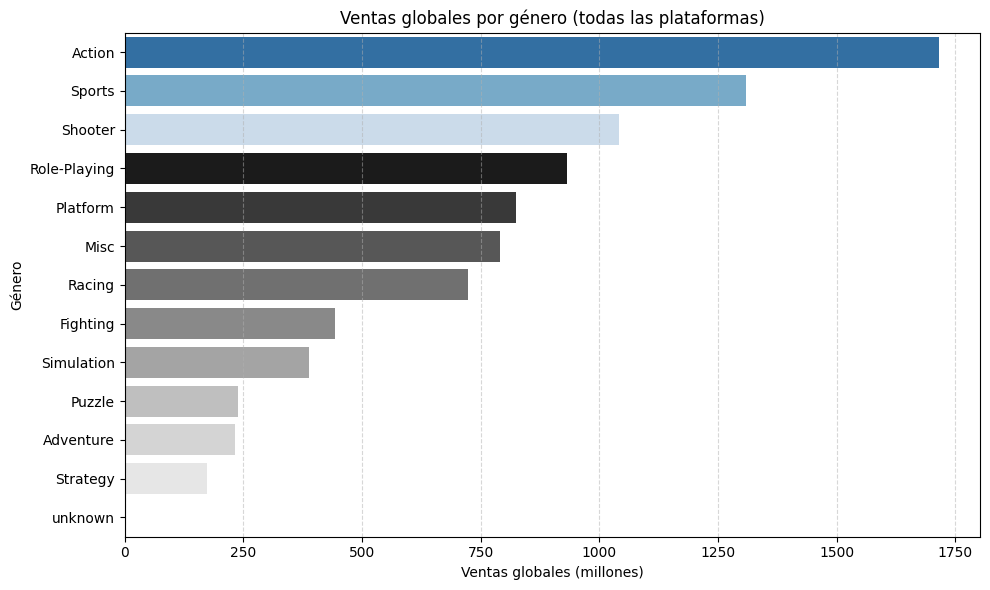

In [97]:
# Agrupar ventas globales por género (todas las plataformas)
genre_sales = (
    games
    .groupby('genre')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

# Identificar top 3 géneros
top3 = genre_sales.index[:3]
others = genre_sales.index[3:]

# Paletas de color
blue_palette = sns.color_palette("Blues", n_colors=3)[::-1]   # azul oscuro → claro
gray_palette = sns.color_palette("Greys", n_colors=len(others))[::-1]

# Construir lista de colores respetando el orden
colors = []
blue_i = 0
gray_i = 0

for genre in genre_sales.index:
    if genre in top3:
        colors.append(blue_palette[blue_i])
        blue_i += 1
    else:
        colors.append(gray_palette[gray_i])
        gray_i += 1

# Gráfica
plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_sales.values,
    y=genre_sales.index,
    palette=colors
)

plt.title('Ventas globales por género (todas las plataformas)')
plt.xlabel('Ventas globales (millones)')
plt.ylabel('Género')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [98]:
#Géneros principales por región
na_plataformas= games.groupby("genre")["na_sales"].sum().sort_values(ascending=False).reset_index()
eu_plataformas= games.groupby("genre")["eu_sales"].sum().sort_values(ascending=False).reset_index()
jp_plataformas= games.groupby("genre")["jp_sales"].sum().sort_values(ascending=False).reset_index()

total_na=na_plataformas["na_sales"].sum()
total_eu=eu_plataformas["eu_sales"].sum()
total_jp=jp_plataformas["jp_sales"].sum()

print("Norteamérica:\n")
print(na_plataformas.head())
print()
print("Europa:\n")
print(eu_plataformas.head())
print()
print("Japón:\n")
print(jp_plataformas.head())

Norteamérica:

      genre  na_sales
0    Action    863.17
1    Sports    671.20
2   Shooter    584.83
3  Platform    444.44
4      Misc    399.57

Europa:

     genre  eu_sales
0   Action    510.99
1   Sports    371.33
2  Shooter    314.52
3   Racing    234.49
4     Misc    210.60

Japón:

          genre  jp_sales
0  Role-Playing    353.39
1        Action    160.14
2        Sports    134.93
3      Platform    130.71
4          Misc    107.02


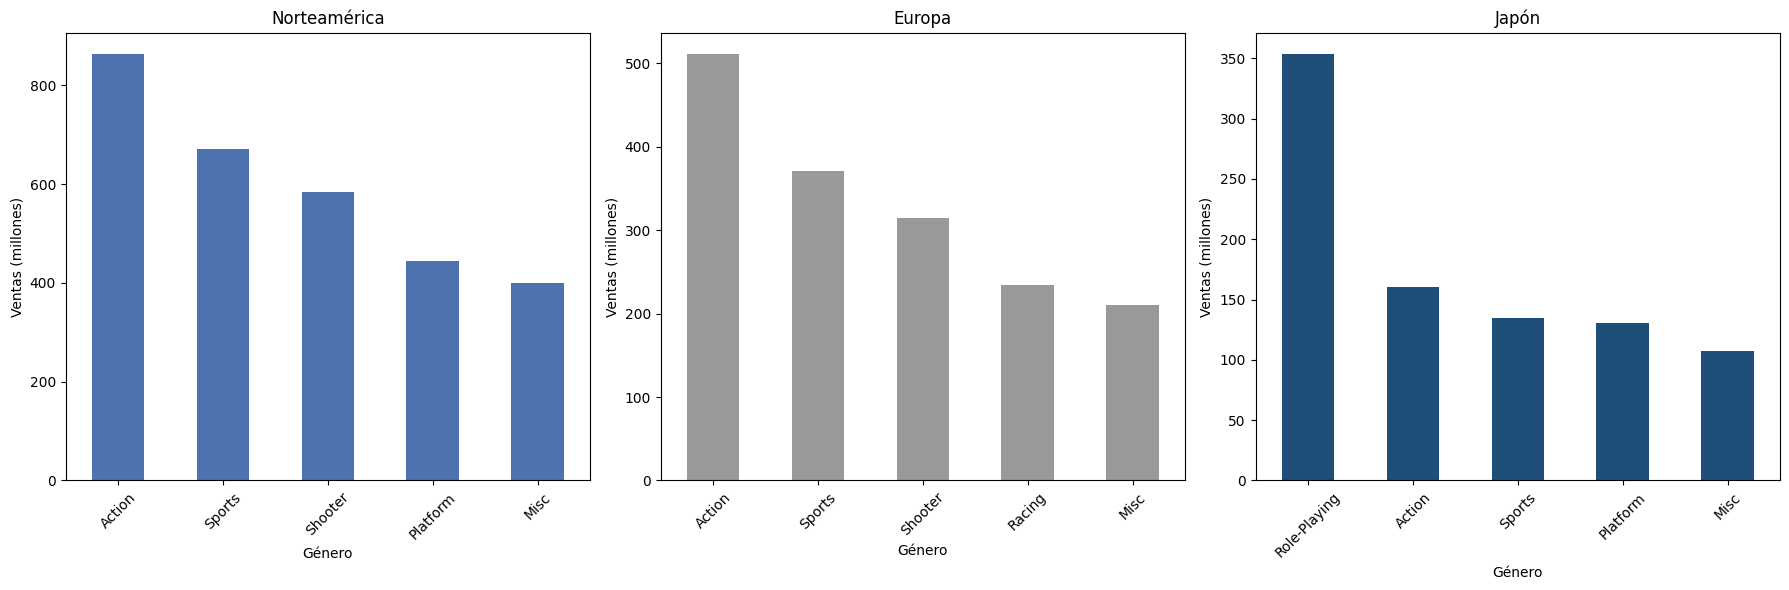

In [99]:
# Función para obtener top 4 géneros y agrupar el resto como "Otros"
def top_genres_with_others(df, sales_col, top_n=5):
    df_sorted = df.groupby("genre")[sales_col].sum().sort_values(ascending=False)
    top_genres = df_sorted.head(top_n)
    return top_genres

# Top géneros por región
na_top = top_genres_with_others(games, "na_sales")
eu_top = top_genres_with_others(games, "eu_sales")
jp_top = top_genres_with_others(games, "jp_sales")

# Crear subplots: 1 fila x 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Gráfico Norteamérica
na_top.plot(kind="bar", ax=axes[0], color="#4C72B0")
axes[0].set_title("Norteamérica")
axes[0].set_xlabel("Género")
axes[0].set_ylabel("Ventas (millones)")
axes[0].tick_params(axis='x', rotation=45)

# Gráfico Europa
eu_top.plot(kind="bar", ax=axes[1], color="#999999")
axes[1].set_title("Europa")
axes[1].set_xlabel("Género")
axes[1].set_ylabel("Ventas (millones)")
axes[1].tick_params(axis='x', rotation=45)

# Gráfico Japón
jp_top.plot(kind="bar", ax=axes[2], color="#1F4E79")
axes[2].set_title("Japón")
axes[2].set_xlabel("Género")
axes[2].set_ylabel("Ventas (millones)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

A nivel global, los géneros con mayor volumen de ventas son Action, Sports y Shooter, consolidándose como los pilares del mercado. No obstante, el análisis segmentado por región revela diferencias en las preferencias de consumo.

En Norteamérica y Europa, los géneros Action y Sports dominan consistentemente las ventas, reflejando patrones de consumo similares entre ambos mercados. En contraste, Japón presenta un comportamiento diferenciado, donde el género Role-Playing lidera las ventas, seguido de Action y Sports. Asimismo, mientras que el género Shooter ocupa una posición destacada en los mercados occidentales, no figura entre los cinco géneros más vendidos en Japón.

Estos resultados evidencian que la popularidad de los géneros varía de forma significativa según la región, lo que sugiere que factores culturales y preferencias locales desempeñan un papel clave en la estructura del mercado.

<a id="segmentacion-esrb"></a>
### Segmentación por clasificación ESRB


/tmp/ipython-input-395860966.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  na_plataformas= known_ratings.groupby("rating")["na_sales"].sum().sort_values(ascending=False).reset_index()
/tmp/ipython-input-395860966.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eu_plataformas= known_ratings.groupby("rating")["eu_sales"].sum().sort_values(ascending=False).reset_index()
/tmp/ipython-input-395860966.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

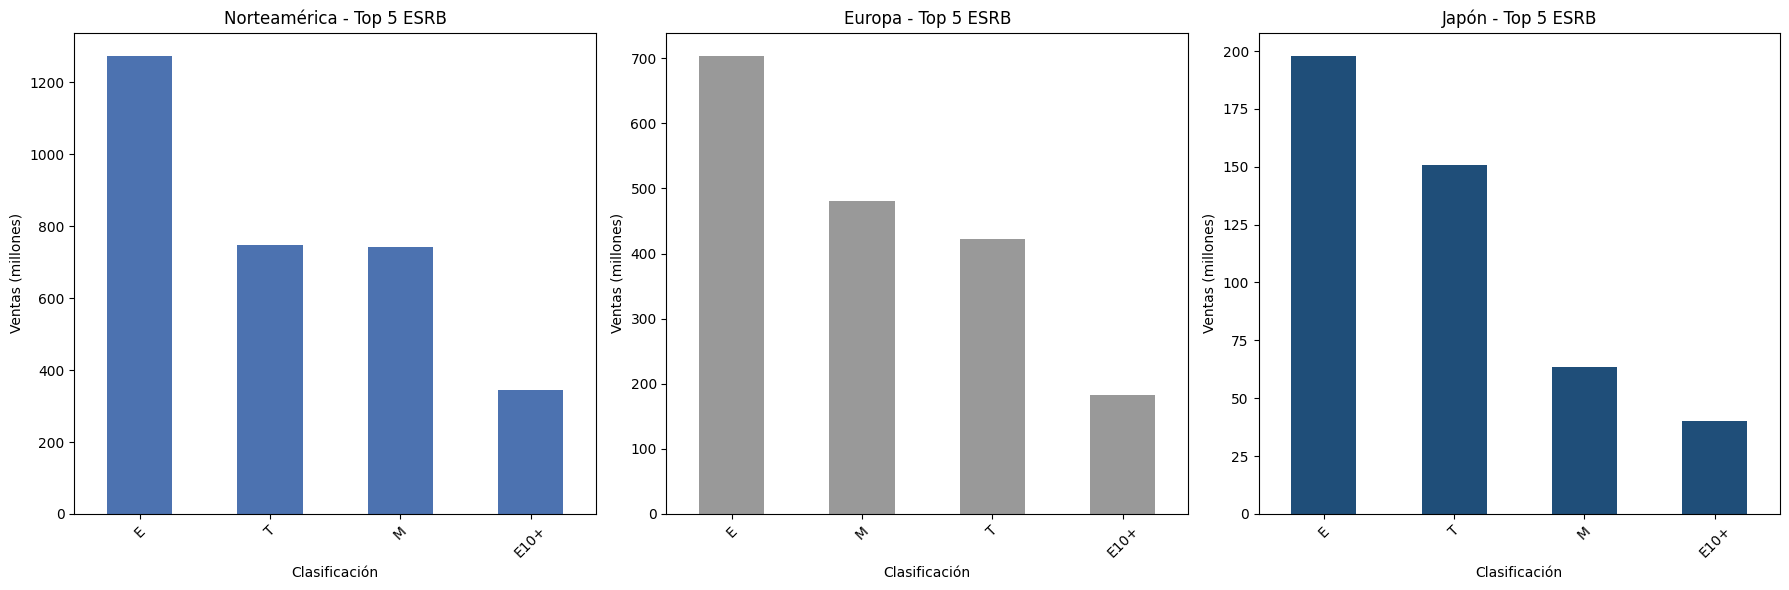

In [100]:
#Agrupar ventas conforme a la clasificación ESRB

# Filtrar valores NAN /unknown
known_ratings = games[games['rating'] != 'unknown']

na_plataformas= known_ratings.groupby("rating")["na_sales"].sum().sort_values(ascending=False).reset_index()
eu_plataformas= known_ratings.groupby("rating")["eu_sales"].sum().sort_values(ascending=False).reset_index()
jp_plataformas= known_ratings.groupby("rating")["jp_sales"].sum().sort_values(ascending=False).reset_index()

total_na=na_plataformas["na_sales"].sum()
total_eu=eu_plataformas["eu_sales"].sum()
total_jp=jp_plataformas["jp_sales"].sum()

def top_ratings(df, sales_col, top_n=4):
    df_sorted = df.groupby("rating")[sales_col].sum().sort_values(ascending=False)
    return df_sorted.head(top_n)

na_top = top_ratings(known_ratings, "na_sales")
eu_top = top_ratings(known_ratings, "eu_sales")
jp_top = top_ratings(known_ratings, "jp_sales")

fig, axes = plt.subplots(1, 3, figsize=(18,6))

na_top.plot(kind="bar", ax=axes[0], color="#4C72B0")
axes[0].set_title("Norteamérica - Top 5 ESRB")
axes[0].set_xlabel("Clasificación")
axes[0].set_ylabel("Ventas (millones)")
axes[0].tick_params(axis='x', rotation=45)

eu_top.plot(kind="bar", ax=axes[1], color="#999999" )
axes[1].set_title("Europa - Top 5 ESRB")
axes[1].set_xlabel("Clasificación")
axes[1].set_ylabel("Ventas (millones)")
axes[1].tick_params(axis='x', rotation=45)

jp_top.plot(kind="bar", ax=axes[2], color="#1F4E79")
axes[2].set_title("Japón - Top 5 ESRB")
axes[2].set_xlabel("Clasificación")
axes[2].set_ylabel("Ventas (millones)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/tmp/ipython-input-4011143637.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  na_avg = games.groupby('rating')['na_sales'].mean().sort_values(ascending=False).reset_index()
/tmp/ipython-input-4011143637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eu_avg = games.groupby('rating')['eu_sales'].mean().sort_values(ascending=False).reset_index()
/tmp/ipython-input-4011143637.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this

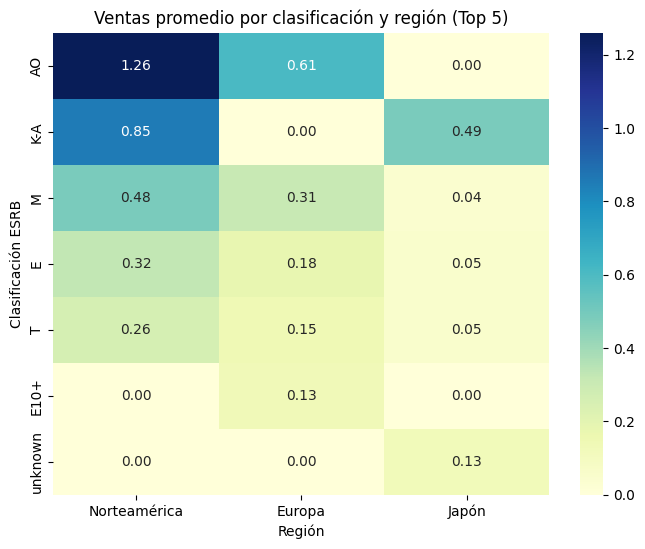

In [107]:
na_avg = games.groupby('rating')['na_sales'].mean().sort_values(ascending=False).reset_index()
eu_avg = games.groupby('rating')['eu_sales'].mean().sort_values(ascending=False).reset_index()
jp_avg = games.groupby('rating')['jp_sales'].mean().sort_values(ascending=False).reset_index()


# Top 5 clasificaciones por promedio en cada región
top5_na = na_avg['rating'].head(5).tolist()
top5_eu = eu_avg['rating'].head(5).tolist()
top5_jp = jp_avg['rating'].head(5).tolist()


top5_all = list(pd.unique(top5_na + top5_eu + top5_jp))


heatmap_df = pd.DataFrame(index=top5_all, columns=['Norteamérica','Europa','Japón'])


for rating in top5_all:
    heatmap_df.loc[rating, 'Norteamérica'] = na_avg.loc[na_avg['rating']==rating, 'na_sales'].values[0] if rating in top5_na else 0
    heatmap_df.loc[rating, 'Europa'] = eu_avg.loc[eu_avg['rating']==rating, 'eu_sales'].values[0] if rating in top5_eu else 0
    heatmap_df.loc[rating, 'Japón'] = jp_avg.loc[jp_avg['rating']==rating, 'jp_sales'].values[0] if rating in top5_jp else 0

heatmap_df = heatmap_df.astype(float)


plt.figure(figsize=(8,6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Ventas promedio por clasificación y región (Top 5)")
plt.ylabel("Clasificación ESRB")
plt.xlabel("Región")
plt.show()


A nivel de ventas totales, las clasificaciones E, T y M concentran la mayor parte del mercado en las tres regiones, lo que indica que estos rangos de edad dominan la oferta y el consumo global de videojuegos. Si embargo, aunque E y T lideran en ventas totales, su venta promedio por título es relativamente moderada, lo que sugiere que su alto desempeño se debe a la gran cantidad de lanzamientos más que a éxitos individuales extremadamente altos. En contraste, clasificaciones menos frecuentes como AO y KA presentan ventas promedio más elevadas en regiones específicas (principalmente Norteamérica y, en menor medida, Europa y Japón), indicando que, aunque son poco comunes, algunos de estos títulos alcanzan ventas muy altas.

Desde una perspectiva regional, Japón muestra un patrón distinto: las ventas totales son menores y las ventas promedio por título son bajas para la mayoría de las clasificaciones, con la excepción de KA, que destaca frente a E, T y M. Esto refuerza la idea de que el mercado japonés prioriza títulos dirigidos a   nichos muy específicos, en contraste con los mercados occidentales.



<a id="inferencial"></a>
## Análisis inferencial: pruebas de hipótesis



In [104]:
#H0: las calificaciones promedio de los usuarios para Xbox One y Pc =

#Ha: las calificaciones promedio de los usuarios para Xbox One y Pc !=

xbox_one = games[games['platform'] == 'XOne']['user_score']
pc= games[games['platform'] == 'PC']['user_score']

#Prueba d eigualdad de varianzas
stat,p=levene(xbox_one,pc)
print("Valor-p de la prueba de Levene:", p)

if p < 0.05:
    print("Rechazamos H0: las varianzas son significativamente diferentes → usar equal_var=False")
else:
    print("No rechazamos H0: no hay evidencia de varianzas diferentes → puedes usar equal_var=True")

#Prueba de hipótesis (medias independientes)

resultado=st.ttest_ind(xbox_one, pc, equal_var=True)

print("Valor-p de la prueba T:", resultado.pvalue)

if resultado.pvalue < 0.05:
    print("Rechazamos H0: las medias son significativamente diferentes")
else:
    print("No rechazamos H0: no hay evidencia de diferencias significativas entre las medias")


Valor-p de la prueba de Levene: nan
No rechazamos H0: no hay evidencia de varianzas diferentes → puedes usar equal_var=True
Valor-p de la prueba T: nan
No rechazamos H0: no hay evidencia de diferencias significativas entre las medias



El resultado de la prueba t muestra que no se rechaza la hipótesis nula, es decir, no hay evidencia estadística suficiente para afirmar que las calificaciones promedio de los usuarios difieren significativamente entre Xbox One y PC.

Esto sugiere esto sugiere que las diferencias observadas en ventas u otras métricas no estarían explicadas por una diferencia en las calificaciones de los jugadores.


In [105]:
#H0: las calificaciones promedio de los usuarios para  acción y deportes =

#Ha: las calificaciones promedio de los usuarios para aciión y deportes !=

action = games[games['genre'] == 'Action']['user_score']
sports = games[games['genre'] == 'Sports']['user_score']

#Prueba d eigualdad de varianzas
stat,p=levene(action,sports)
print("Valor-p de la prueba de Levene:", p)

if p < 0.05:
    print("Rechazamos H0: las varianzas son significativamente diferentes → usar equal_var=False")
else:
    print("No rechazamos H0: no hay evidencia de varianzas diferentes → puedes usar equal_var=True")

#Prueba de hipótesis (medias independientes)

resultado=st.ttest_ind(action, sports, equal_var=True)

print("Valor-p de la prueba T:", resultado.pvalue)

if resultado.pvalue < 0.05:
    print("Rechazamos H0: las medias son significativamente diferentes")
else:
    print("No rechazamos H0: no hay evidencia de diferencias significativas entre las medias")


Valor-p de la prueba de Levene: nan
No rechazamos H0: no hay evidencia de varianzas diferentes → puedes usar equal_var=True
Valor-p de la prueba T: nan
No rechazamos H0: no hay evidencia de diferencias significativas entre las medias


El resultado de la prueba t muestra que no se rechaza la hipótesis nula, lo que indica que no existen diferencias estadísticamente significativas entre las calificaciones promedio otorgadas por los usuarios a los juegos de acción y deportes.

Aunque Action y Sports son géneros líderes en ventas, su desempeño comercial no está asociado a una diferencia en la percepción de calidad por parte de los usuarios, sino probablemente a factores como tamaño del mercado, frecuencia de lanzamientos, franquicias establecidas o estrategias de distribución.

<a id="conclusiones"></a>
## Conclusiones y recomendaciones


El análisis confirma que el mercado de videojuegos está fuertemente determinado por el ciclo de vida de las plataformas y las preferencias regionales. Aunque Xbox 360 y Wii destacan como plataformas históricamente exitosas y aún relevantes, el liderazgo actual se concentra en PS4, Xbox One y 3DS, plataformas relativamente más recientes que dominan el mercado occidental, con la 3DS mostrando un impacto particularmente fuerte en Japón.

A nivel de contenido, los géneros Action y Sports concentran la mayor rentabilidad en Norteamérica y Europa, mientras que Role-Playing lidera claramente en Japón, evidenciando diferencias culturales en el consumo. En cuanto a clasificaciones, la categoría E (Everyone) genera el mayor volumen total de ventas; sin embargo, las clasificaciones AO en Occidente y K-A en Japón, aunque más pequeñas en número de títulos, presentan mayores ventas promedio por juego, consolidándose como nichos rentables.

Finalmente, las pruebas estadísticas indican que las calificaciones promedio de los usuarios no presentan diferencias significativas entre plataformas ni entre géneros líderes, lo que sugiere que el éxito comercial depende más de factores de mercado —plataforma, región y posicionamiento— que de variaciones en la percepción de calidad.

En términos estratégicos, para maximizar ventas se recomienda priorizar PS4, Xbox One y 3DS, enfocar el desarrollo en Action y Sports para mercados occidentales, Role-Playing para Japón, y considerar tanto categorías masivas (E) como nichos de alto retorno (AO/K-A) según la región objetivo.